In [1]:
!/opt/bin/nvidia-smi

Fri May 20 06:14:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **1. Prepare Dataset**

## 1.1. Download Dataset and Install Environment

In [2]:
!pip install SentencePiece
!pip install transformers
!pip install -U -q PyDrive
!pip install efficientnet_pytorch
!pip install pytorchtools
!pip install ipython-autotime

%load_ext autotime
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '18S9K70mChSDbGGh7Pv2WnOPD8PjSz5kx' 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dataset.zip')

!unzip Dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._15531.jpg  
  inflating: COMP5329S1A2Dataset/data/12538.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._12538.jpg  
  inflating: COMP5329S1A2Dataset/data/25394.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._25394.jpg  
  inflating: COMP5329S1A2Dataset/data/35187.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._35187.jpg  
  inflating: COMP5329S1A2Dataset/data/7710.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._7710.jpg  
  inflating: COMP5329S1A2Dataset/data/8423.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._8423.jpg  
  inflating: COMP5329S1A2Dataset/data/15257.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._15257.jpg  
  inflating: COMP5329S1A2Dataset/data/34299.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._34299.jpg  
  inflating: COMP5329S1A2Dataset/data/14149.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._14149.jpg  
  inflating: COMP5329S1A2Dat

## 1.2. Loading Data

In [3]:
import re
import torch
import pandas as pd
import numpy as np
from io import StringIO

# set the data path
train_path = '/content/COMP5329S1A2Dataset/train.csv'
test_path = '/content/COMP5329S1A2Dataset/test.csv'

with open(train_path) as file:
    data = file.readlines()# Read each data in list
for i in [4790, 14716, 14961, 29895]: #These data rows all contain "/" at the end of the title, which would make them unreadable
    data[i] = data[i].replace("/", "")      
with open(train_path, 'w') as file: #Save modification
    file.writelines(data)

# load data to dataframe
with open(train_path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    train_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(test_path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    test_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

# remove all "
train_data = train_data.drop(columns = 'Caption').join(train_data['Caption'].str.replace('\"', ''))
test_data = test_data.drop(columns = 'Caption').join(test_data['Caption'].str.replace('\"', ''))

# print the data shape
print("------------------------------------")
print("Shape of training dataset: {}".format(train_data.shape))
print("Shape of testing dataset: {}".format(len(test_data.shape)))
print("------------------------------------")

------------------------------------
Shape of training dataset: (30000, 3)
Shape of testing dataset: 2
------------------------------------
time: 3.75 s (started: 2022-05-20 06:15:16 +00:00)


In [4]:
# show train head data
train_data.head(10)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
5,5.jpg,1,A young man riding a skateboard into the air.
6,6.jpg,5,A big airplane flying in the big blue sky
7,7.jpg,1 4,A man riding a motor bike across a forest.
8,8.jpg,8 3,There is a street lined with packed buildings
9,9.jpg,1 18 15,A skate park next to a body of water and green...


time: 11.8 ms (started: 2022-05-20 06:15:19 +00:00)


## 1.3. Sample Cleaning for Caption

Define Preprocess Caption Function

In [5]:
# def preprocess_caption(caption):
#     preprocessed_captions=[]
#     for c in caption:
#         clean_caption = re.sub(r'[^A-Za-z]+', ' ', c)#Remove number and punctuations
#         clean_caption = clean_caption.lower() #Lowercase
#         preprocessed_captions.append(clean_caption)
#     return preprocessed_captions

time: 1.78 ms (started: 2022-05-20 06:15:19 +00:00)


Create copies of the train and test datasets, perform simple processing and put the processed data back into the dataframe

In [6]:
# copy data from train_data, test_data
train_df = train_data.copy()
test_df = test_data.copy()
# caption_train = preprocess_caption(train_df['Caption'].tolist())
# caption_test = preprocess_caption(test_df['Caption'].tolist())
# train_df['Caption'] = caption_train
# test_df['Caption'] = caption_test
train_df.head(10)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
5,5.jpg,1,A young man riding a skateboard into the air.
6,6.jpg,5,A big airplane flying in the big blue sky
7,7.jpg,1 4,A man riding a motor bike across a forest.
8,8.jpg,8 3,There is a street lined with packed buildings
9,9.jpg,1 18 15,A skate park next to a body of water and green...


time: 13.5 ms (started: 2022-05-20 06:15:20 +00:00)


## 1.4. Label Encoding

Show labels Count

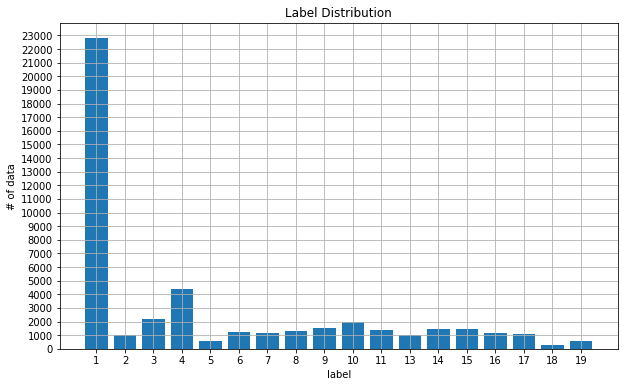

time: 360 ms (started: 2022-05-20 06:15:20 +00:00)


In [7]:
import matplotlib.pyplot as plt
# label set
label_list = {}
for i in train_df['Labels']:
    for j in i.split():
        label_list.setdefault(int(j), 0)
        label_list[int(j)] += 1

plt.figure(figsize=(10,6))
plt.bar(range(len(label_list)), list(label_list.values()), align='center')
plt.xticks(range(len(label_list)), sorted(list(label_list.keys())))
plt.xlabel('label')
plt.ylabel('# of data')
plt.yticks(np.arange(0, 24000, step=1000))
plt.grid()
plt.title("Label Distribution")
plt.show()

The label is processed using the MultiLabelBinarizer and the processed data is put back into the dataframe

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
# encode labels for train data
labels = []
for i in train_df['Labels']:
    labels.append(i.split())
labels = [sorted(int(j) for j in i) for i in labels]

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(labels)
print("shape of label_encoded: ", np.array(label_encoded).shape)
print("all classes: ", mlb.classes_)

shape of label_encoded:  (30000, 18)
all classes:  [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19]
time: 546 ms (started: 2022-05-20 06:15:20 +00:00)


In [9]:
train_df['Labels'] = list(label_encoded)
train_df.head(10)

,ImageID,Labels,Caption
0,0.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Woman in swim suit holding parasol on sunny day.
1,1.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A couple of men riding horses on top of a gree...
2,2.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",They are brave for riding in the jungle on tho...
3,3.jpg,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",a black and silver clock tower at an intersect...
4,4.jpg,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",A train coming to a stop on the tracks out side.
5,5.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A young man riding a skateboard into the air.
6,6.jpg,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A big airplane flying in the big blue sky
7,7.jpg,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A man riding a motor bike across a forest.
8,8.jpg,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",There is a street lined with packed buildings
9,9.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",A skate park next to a body of water and green...


time: 24.2 ms (started: 2022-05-20 06:15:20 +00:00)


# **2. Build Albert Model**

## 2.1. Defining Seq-length

Combine the train dataset and test dataset together

In [43]:
whole_df = pd.concat([train_df['Caption'], test_df['Caption']], axis=0, ignore_index=True)
word_count = whole_df.apply(lambda x: len(x.split()))
print("size of word_count: ", len(word_count))

size of word_count:  40000
time: 40.3 ms (started: 2022-05-19 19:50:07 +00:00)


Use the length covering 95% of the captions as the max seq length

seq_length:  14
max_length:  49


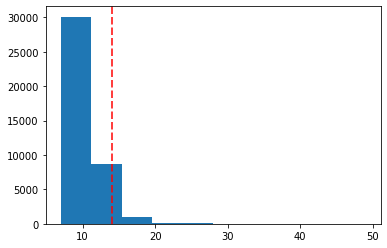

time: 173 ms (started: 2022-05-19 19:50:08 +00:00)


In [44]:
import matplotlib.pyplot as plt
seq_length = int(np.percentile(word_count, 95))
print("seq_length: ", seq_length)
print("max_length: ", max(word_count))
plt.hist(word_count)
plt.axvline(x=seq_length,color="red",dashes=[5,2])
plt.show()

## 2.2. Defining Costum Dataset

Create a CostumnDataset and preprocess the dataset with albert's tokenizer

In [45]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, isTest=False):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.isTest = isTest
        self.caption = dataframe['Caption']
        self.labels = dataframe['Labels'] if not isTest else None
        self.max_len = max_len
 

    def __len__(self):
        return len(self.caption)

    def __getitem__(self, index):
        caption = str(self.caption[index])
        caption = " ".join(caption.split())
        
        encoding = self.tokenizer.encode_plus(
            caption,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True

        )

        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        token_type_ids = encoding["token_type_ids"]
        output = {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels': torch.tensor(self.labels[index], dtype=torch.float) 
        } if not self.isTest else {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }
        return output


time: 14.8 ms (started: 2022-05-19 19:50:10 +00:00)


## 2.3. Defining Train / Valid Loader




In [46]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_valid_split(train_df):
    train_dataset, valid_dataset = train_test_split(train_df, test_size = 0.2, random_state=42)
    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)
    return train_dataset, valid_dataset

def create_bert_train_valid_loader(train_dataset, valid_dataset, tokenizer, train_batch_size, valid_batch_size, seq_length):
    training_set = CustomDataset(train_dataset, tokenizer, seq_length)
    validation_set = CustomDataset(valid_dataset, tokenizer, seq_length)
    
    training_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_set, batch_size=valid_batch_size, shuffle=True, num_workers=2)
    return training_loader, validation_loader


def show_train_valid(train_dataset, valid_dataset):
    train_label_list = {}
    for i in train_dataset['Labels']:
        for idx,j in enumerate(i):
            if idx < 11:
                train_label_list.setdefault(idx+1, 0)
                if j == 1:
                    train_label_list[idx+1] += 1
            elif idx > 11:
                train_label_list.setdefault(idx+2, 0)
                if j == 1:
                    train_label_list[idx+2] += 1
    val_label_list = {}
    for i in valid_dataset['Labels']:
        for idx,j in enumerate(i):
            if idx < 11:
                val_label_list.setdefault(idx+1, 0)
                if j == 1:
                    val_label_list[idx+1] += 1
            elif idx > 11:
                val_label_list.setdefault(idx+2, 0)
                if j == 1:
                    val_label_list[idx+2] += 1
                    
    plt.figure(figsize=(10,6))
    x = np.arange(len(val_label_list))
    width = 0.25
    plt.bar(x - width/2, [i/24000 for i in list(train_label_list.values())], width, label='Train')
    plt.bar(x + width/2, [i/6000 for i in list(val_label_list.values())], width, label='Validation')
    plt.xticks(x, sorted(list(train_label_list.keys())))
    plt.legend()
    plt.xlabel('label')
    plt.ylabel('% of data')
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.grid()
    plt.title("Train/Valid Label Distribution")
    plt.show()


time: 284 ms (started: 2022-05-19 19:50:13 +00:00)


## 2.4. Defining AlBert Model

In [47]:
from transformers import AlbertModel
from torch import nn
class AlBertClassifier(nn.Module):
    def __init__(self, dropout=0.3, n_classes=18):
        super(AlBertClassifier, self).__init__()
        self.bert = AlbertModel.from_pretrained('albert-base-v2') # cased
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids):
        _, bert_output = self.bert(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False) # , return_dict=False
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output

time: 6.03 ms (started: 2022-05-19 19:50:14 +00:00)


## 2.5. Train and Evaluate Model

### Define train/evaluate/predict function

In [60]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
def calculate_f1(labels, outputs, threshold=0.5):
    outputs = (np.array(outputs) > threshold)*1
    accuracy = accuracy_score(list(labels), outputs)
    f1_score_micro = f1_score(labels, outputs, average='micro')
    f1_score_macro = f1_score(labels, outputs, average='macro')
    f1_score_sample = f1_score(labels, outputs, average='samples')
    f1_score_weighted = f1_score(labels, outputs, average='weighted')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"F1 Score (sample) = {f1_score_sample}")
    print(f"F1 Score (weighted) = {f1_score_weighted}")
    return f1_score_sample

def train(model, optimizer, criterion, training_loader, device): 
    model.train()

    train_loss = []
    train_labels = []
    train_outputs = []
    for data in tqdm(training_loader, total=len(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.float)
        
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)

        loss = criterion(outputs, labels)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        train_labels.extend(labels.cpu().detach().numpy().tolist())
        train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    train_loss = np.average(train_loss)
    return train_outputs, train_labels, train_loss

def validation(model, criterion, validation_loader, device):
    model.eval()

    val_loss = []
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for data in tqdm(validation_loader, total=len(validation_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            val_labels.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        val_loss = np.average(val_loss)
    return val_outputs, val_labels, val_loss

def fit(model, epochs, optimizer, criterion, training_loader, validation_loader, device, threshold=0.5):
    t_loss = []
    v_loss = []
    t_f1 = []
    v_f1 = []
    best_val_loss = 1000
    best_f1 = 0
    desc_count = 0
    for epoch in range(epochs):
        train_outputs, train_labels, train_loss = train(model, optimizer, criterion, training_loader, device)
        train_f1 = calculate_f1(train_labels, train_outputs, threshold)
        t_loss.append(train_loss)
        t_f1.append(train_f1)
        val_outputs, val_labels, val_loss = validation(model, criterion, validation_loader, device)
        val_f1 = calculate_f1(val_labels, val_outputs, threshold)
        v_loss.append(val_loss)
        v_f1.append(val_f1)
        print('Epoch: {}/{} | Training Loss: {:.6f}, Training F1: {:.4f} | Validation Loss: {:.6f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,train_f1,val_loss,val_f1))
        # print('Epoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,val_loss,val_f1))

        if val_loss < best_val_loss:
            desc_count = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'nlp_checkpoint.pt')
            print("\n** Checkpoint Saved!\n")

            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save(model.state_dict(), 'nlp_best_f1.pt')

        elif val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'nlp_best_f1.pt')
            print("\n** Best F1 checkpoint saved!\n")
        else:
            desc_count += 1
        
        if desc_count >= 3:
            print("Early Stopped At Epoch: {} / {}".format(epoch+1, epochs))
            break

    best_model = AlBertClassifier().to(device)
    best_model.load_state_dict(torch.load('nlp_checkpoint.pt'))
    
    return best_model,t_loss,t_f1,v_loss,v_f1

def predict(model, test_df, tokenizer, seq_length, test_batch_size, device):
    test_set = CustomDataset(test_df, tokenizer, seq_length, True)
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)
    model.eval()

    test_outputs = []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            test_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    res = (np.array(test_outputs) > 0.5)*1
    return res

time: 281 ms (started: 2022-05-19 19:59:59 +00:00)


### Set hyperparameters

In [67]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
from torch.optim import AdamW, Adam
from transformers import AlbertTokenizer, AlbertModel
# Sections of config
seq_length = seq_length
n_classes = len(mlb.classes_)
train_batch_size = 32
valid_batch_size = 32
test_batch_size = 32
epochs = 40
learning_rates = 1e-5

time: 6.63 ms (started: 2022-05-19 20:03:55 +00:00)


### Create train/valid dataset

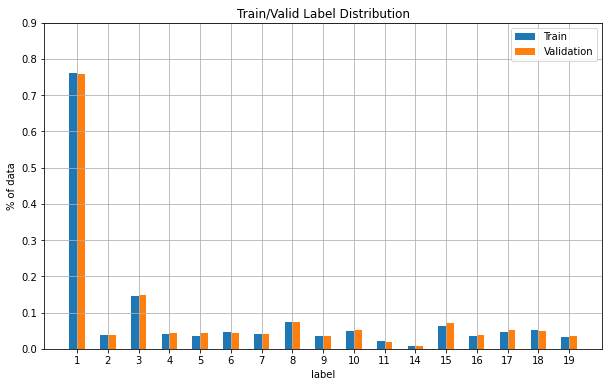

time: 4.21 s (started: 2022-05-19 20:03:58 +00:00)


In [68]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2') # uncased
# create train validation data loader
train_dataset, valid_dataset = train_valid_split(train_df)
training_loader, validation_loader = create_bert_train_valid_loader(train_dataset, valid_dataset, tokenizer, train_batch_size, valid_batch_size, seq_length)
# show the labels distribution of train and validation dataset
show_train_valid(train_dataset, valid_dataset)

### Train model

In [71]:
# train model
# Move the model to GPU
model = AlBertClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = Adam(params=model.parameters(), lr=learning_rates)
optimizer = AdamW(params=model.parameters(), lr=learning_rates)

nlp_best_model, nlp_train_loss, nlp_train_f1, nlp_valid_loss, nlp_valid_f1 = fit(model, epochs, optimizer, criterion, training_loader, validation_loader, device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.5490416666666667
F1 Score (Micro) = 0.6903348033050483
F1 Score (Macro) = 0.3719110875637513
F1 Score (sample) = 0.7215216836404336
F1 Score (weighted) = 0.621133997261584


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6343333333333333
F1 Score (Micro) = 0.788768898488121
F1 Score (Macro) = 0.6071261912831178
F1 Score (sample) = 0.8275653439153439
F1 Score (weighted) = 0.7434014440848624
Epoch: 1/40 | Training Loss: 0.154806, Training F1: 0.7215 | Validation Loss: 0.108255, Validation F1: 0.8276

** Checkpoint Saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.657625
F1 Score (Micro) = 0.8063238698671866
F1 Score (Macro) = 0.6738760127482915
F1 Score (sample) = 0.8410651455026454
F1 Score (weighted) = 0.7769909621713507


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6605
F1 Score (Micro) = 0.8124207092369964
F1 Score (Macro) = 0.709223462718072
F1 Score (sample) = 0.8476236772486773
F1 Score (weighted) = 0.7881063747163282
Epoch: 2/40 | Training Loss: 0.100080, Training F1: 0.8411 | Validation Loss: 0.097044, Validation F1: 0.8476

** Checkpoint Saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.674875
F1 Score (Micro) = 0.8203194521952912
F1 Score (Macro) = 0.7167786924971906
F1 Score (sample) = 0.8544594696969698
F1 Score (weighted) = 0.7964905875224417


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6595
F1 Score (Micro) = 0.8135775862068966
F1 Score (Macro) = 0.6789326430791495
F1 Score (sample) = 0.8478714285714286
F1 Score (weighted) = 0.7874303408636588
Epoch: 3/40 | Training Loss: 0.091029, Training F1: 0.8545 | Validation Loss: 0.093572, Validation F1: 0.8479

** Checkpoint Saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.6601666666666667
F1 Score (Micro) = 0.8067599811547288
F1 Score (Macro) = 0.6779699283559986
F1 Score (sample) = 0.8383965999278499
F1 Score (weighted) = 0.7795279123865919


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6465
F1 Score (Micro) = 0.809945665012993
F1 Score (Macro) = 0.6703292671882375
F1 Score (sample) = 0.846594708994709
F1 Score (weighted) = 0.7815132545610106
Epoch: 4/40 | Training Loss: 0.095333, Training F1: 0.8384 | Validation Loss: 0.095454, Validation F1: 0.8466


  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.676625
F1 Score (Micro) = 0.8230572673981662
F1 Score (Macro) = 0.7181607202500654
F1 Score (sample) = 0.8581012475949975
F1 Score (weighted) = 0.8002193389693595


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6661666666666667
F1 Score (Micro) = 0.8209288653733098
F1 Score (Macro) = 0.7294915452471311
F1 Score (sample) = 0.8583075396825397
F1 Score (weighted) = 0.8015741089782689
Epoch: 5/40 | Training Loss: 0.088212, Training F1: 0.8581 | Validation Loss: 0.091385, Validation F1: 0.8583

** Checkpoint Saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.6874583333333333
F1 Score (Micro) = 0.8327013227434236
F1 Score (Macro) = 0.7422865793820991
F1 Score (sample) = 0.8667396194083694
F1 Score (weighted) = 0.812336454017597


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6601666666666667
F1 Score (Micro) = 0.8204381263108833
F1 Score (Macro) = 0.7270975652167944
F1 Score (sample) = 0.8594157407407408
F1 Score (weighted) = 0.7968810399423606
Epoch: 6/40 | Training Loss: 0.082837, Training F1: 0.8667 | Validation Loss: 0.091694, Validation F1: 0.8594

** Best F1 checkpoint saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.6984166666666667
F1 Score (Micro) = 0.8411592566734504
F1 Score (Macro) = 0.7541360601136168
F1 Score (sample) = 0.8747128306878306
F1 Score (weighted) = 0.8223305929520411


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6721666666666667
F1 Score (Micro) = 0.8219743907476249
F1 Score (Macro) = 0.7267267476341337
F1 Score (sample) = 0.8604244708994709
F1 Score (weighted) = 0.7970674136309375
Epoch: 7/40 | Training Loss: 0.078337, Training F1: 0.8747 | Validation Loss: 0.090734, Validation F1: 0.8604

** Checkpoint Saved!



  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.70525
F1 Score (Micro) = 0.8490421002838221
F1 Score (Macro) = 0.7646238377016913
F1 Score (sample) = 0.8812689239001739
F1 Score (weighted) = 0.8320237027853726


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6661666666666667
F1 Score (Micro) = 0.8172362555720653
F1 Score (Macro) = 0.7258215948464773
F1 Score (sample) = 0.8547611111111111
F1 Score (weighted) = 0.796577110480429
Epoch: 8/40 | Training Loss: 0.073498, Training F1: 0.8813 | Validation Loss: 0.091496, Validation F1: 0.8548


  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.7210416666666667
F1 Score (Micro) = 0.860704241856105
F1 Score (Macro) = 0.7825348525598259
F1 Score (sample) = 0.8920492063492064
F1 Score (weighted) = 0.846474380047719


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6625
F1 Score (Micro) = 0.8173645611544832
F1 Score (Macro) = 0.7307275963444482
F1 Score (sample) = 0.8527932539682539
F1 Score (weighted) = 0.7974413796794662
Epoch: 9/40 | Training Loss: 0.067829, Training F1: 0.8920 | Validation Loss: 0.094356, Validation F1: 0.8528


  0%|          | 0/1500 [00:00<?, ?it/s]

Accuracy Score = 0.7370416666666667
F1 Score (Micro) = 0.8725336583101206
F1 Score (Macro) = 0.7971574566083421
F1 Score (sample) = 0.9018429047804047
F1 Score (weighted) = 0.8609004869905375


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy Score = 0.6598333333333334
F1 Score (Micro) = 0.8138329209379049
F1 Score (Macro) = 0.7237026940627644
F1 Score (sample) = 0.853037962962963
F1 Score (weighted) = 0.792224375054981
Epoch: 10/40 | Training Loss: 0.061628, Training F1: 0.9018 | Validation Loss: 0.097306, Validation F1: 0.8530
Early Stopped At Epoch: 10 / 40


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


time: 15min 54s (started: 2022-05-19 20:39:46 +00:00)


### Save model

In [ ]:
# torch.save(nlp_best_model.state_dict(), 'albert.pt')

time: 112 ms (started: 2022-05-16 13:44:53 +00:00)


# **3. Build EfficientNetB3 Model**

## 3.1. Defining Costum CV Dataset

### Define Dataset

In [10]:
def expend_img(img):
    fill_pix=[0,0,0]
    h,w=img.shape[:2]
    if h>=w:
        padd_width=int(h-w)//2
        padd_top,padd_bottom,padd_left,padd_right=0,0,padd_width,padd_width
    elif h<w:
        padd_high=int(w-h)//2
        padd_top,padd_bottom,padd_left,padd_right=padd_high,padd_high,0,0
    new_img = cv2.copyMakeBorder(img,padd_top,padd_bottom,padd_left,padd_right,cv2.BORDER_CONSTANT, value=fill_pix)
    return new_img

time: 8.39 ms (started: 2022-05-19 14:20:00 +00:00)


In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import cv2
import os

class CustomCVDataset(Dataset):
    def __init__(self, dataframe, mod='Train'):
        self.data = dataframe
        self.mod = mod
        self.images = dataframe['ImageID']
        self.labels = dataframe['Labels'] if mod != 'Test' else None
 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.images[index])
        # img = Image.open(img_path)
        img = cv2.imread(img_path)
        img = expend_img(img)

        if self.mod=='Train':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                # transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomHorizontalFlip(),
                                # transforms.Grayscale(),
                                transforms.ColorJitter(),
                                transforms.RandomAffine(
                                        degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                        shear=None, resample=False, 
                                        fill=tuple(np.array(np.array([0.485, 0.456, 0.406])*255).astype(int).tolist())),
                                # transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
        elif self.mod == 'Validation':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        elif self.mod == 'Test': # test
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])                       

        image = transform(img)

        output = {
            # 'images': torch.tensor(image, dtype=torch.float32),
            'images': image.clone().detach(),
            # 'labels': self.labels[index].clone().detach()
            'labels': torch.tensor(self.labels[index], dtype=torch.float32) 
        } if self.mod != 'Test' else {
            # 'images': torch.tensor(image)
            'images': image.clone().detach()
        }
        return output

time: 546 ms (started: 2022-05-19 14:20:00 +00:00)


### Show Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


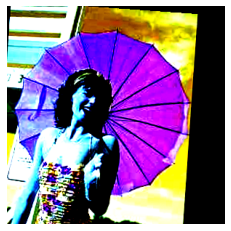

label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
time: 227 ms (started: 2022-05-19 14:20:01 +00:00)


In [12]:
# Check transformed image, binarized label and caption
sample_data = CustomCVDataset(train_df, "Train")

def transformed_image(sample):
    img = sample.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# print(sample_data[0])

transformed_image(sample_data[0]['images']) #Tensor, size=[3, 256, 256]
# print(f'encoded_caption: {sample_data[0][1]}')#ndarray, length=28
# print(f'caption: {sample_data[0][2]}') #str
print(f'label: {sample_data[0]["labels"]}') #ndarray, length=18

## 3.2. Defining CV Train / Valid Loader

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def create_cv_train_valid_loader(train_df, train_batch_size, valid_batch_size):
    train_dataset, valid_dataset = train_test_split(train_df, test_size = 0.2, random_state=42)
    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)
    training_set = CustomCVDataset(train_dataset, mod='Train')
    validation_set = CustomCVDataset(valid_dataset, mod='Validation')
    
    training_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_set, batch_size=valid_batch_size, shuffle=True, num_workers=2)
    return training_loader, validation_loader

time: 74 ms (started: 2022-05-19 14:20:01 +00:00)


## 3.3. Defining EfficientNetB3 Model

In [14]:
from efficientnet_pytorch import EfficientNet
from torch import nn
# efficientnet = EfficientNet.from_pretrained('efficientnet-b3') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class EffNetB3Classifier(nn.Module):
    def __init__(self, efficientnet=EfficientNet.from_pretrained('efficientnet-b3'), dropout=0.3, n_classes=18):
        super(EffNetB3Classifier, self).__init__()
        efficientnet._fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3
time: 4.38 s (started: 2022-05-19 14:20:01 +00:00)


## 3.4. Train and Evaluate Model

### Define train/evaluate/predict function

In [15]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
def calculate_f1(labels, outputs, threshold=0.5):
    outputs = (np.array(outputs) > threshold)*1
    accuracy = accuracy_score(list(labels), outputs)
    f1_score_micro = f1_score(labels, outputs, average='micro')
    f1_score_macro = f1_score(labels, outputs, average='macro')
    f1_score_sample = f1_score(labels, outputs, average='samples')
    f1_score_weighted = f1_score(labels, outputs, average='weighted')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"F1 Score (sample) = {f1_score_sample}")
    print(f"F1 Score (weighted) = {f1_score_weighted}")
    return f1_score_sample

def cv_train(model, optimizer, criterion, training_loader, device): 
    model.train()

    train_loss = []
    train_labels = []
    train_outputs = []
    for data in tqdm(training_loader, total=len(training_loader)):
        image_torch = data['images'].to(device)
        label_torch = data['labels'].to(device, dtype = torch.float)
        
        optimizer.zero_grad()
        outputs = model(image_torch)

        loss = criterion(outputs, label_torch)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        # train_labels.extend(label_torch.cpu().detach().numpy().tolist())
        # train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        output=outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
        for temp in output:
            train_outputs.append(list(temp))
        label = label_torch.detach().cpu().numpy()
        for temp in label:
            train_labels.append(list(temp))
    train_loss = np.average(train_loss)
    return train_outputs, train_labels, train_loss

def cv_validation(model, criterion, validation_loader, device):
    model.eval()

    val_loss = []
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for data in tqdm(validation_loader, total=len(validation_loader)):
            image_torch = data['images'].to(device)
            label_torch = data['labels'].to(device, dtype = torch.float)

            outputs = model(image_torch)
            loss = criterion(outputs, label_torch)
            val_loss.append(loss.item())

            output=outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in output:
                val_outputs.append(list(temp))
            label = label_torch.detach().cpu().numpy()
            for temp in label:
               val_labels.append(list(temp))
            # val_labels.extend(label_torch.cpu().detach().numpy().tolist())
            # val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        val_loss = np.average(val_loss)
    return val_outputs, val_labels, val_loss

def cv_fit(model, epochs, optimizer, criterion, training_loader, validation_loader, device, threshold=0.5):
    t_loss = []
    v_loss = []
    t_f1 = []
    v_f1 = []

    best_val_loss = 1000
    best_f1 = 0
    desc_count = 0

    for epoch in range(epochs):
        train_outputs, train_labels, train_loss = cv_train(model, optimizer, criterion, training_loader, device)
        train_f1 = calculate_f1(train_labels, train_outputs, threshold)
        t_loss.append(train_loss)
        t_f1.append(train_f1)
        val_outputs, val_labels, val_loss = cv_validation(model, criterion, validation_loader, device)
        val_f1 = calculate_f1(val_labels, val_outputs, threshold)
        v_loss.append(val_loss)
        v_f1.append(val_f1)
        print('Epoch: {}/{} | Training Loss: {:.6f}, Training F1: {:.4f} | Validation Loss: {:.6f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,train_f1,val_loss,val_f1))
        # print('Epoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,val_loss,val_f1))


        if val_loss < best_val_loss:
            desc_count = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'cv_checkpoint.pt')
            print("\n** Checkpoint Saved!\n")

            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save(model.state_dict(), 'cv_best_f1.pt')
                print("\n** Best F1 checkpoint saved!\n")

        elif val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'cv_best_f1.pt')
            print("\n** Best F1 checkpoint saved!\n")
        else:
            desc_count += 1
        
        if desc_count >= 3:
            print("Early Stopped At Epoch: {} / {}".format(epoch+1, epochs))
            break

    return t_loss,t_f1,v_loss,v_f1

def cv_predict(model, test_df, est_batch_size, device):
    test_set = CustomCVDataset(test_df, 'Test')
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)
    model.eval()

    test_outputs = []
    with torch.no_grad():
        for image in test_loader:
            image_torch = image.to(device)

            outputs = model(image_torch)
            test_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    res = (np.array(test_outputs) > 0.5)*1
    return res

time: 162 ms (started: 2022-05-19 14:20:06 +00:00)


### Set hyperparameters

In [16]:
cv_train_batch_size = 32
cv_valid_batch_size = 32
cv_test_batch_size = 32
cv_epochs = 30
cv_learning_rates = 1e-4

time: 1.68 ms (started: 2022-05-19 14:20:06 +00:00)


### Create train/valid dataset

In [17]:
cv_train_loader, cv_valid_loader = create_cv_train_valid_loader(train_df, cv_train_batch_size, cv_valid_batch_size)

time: 9.61 ms (started: 2022-05-19 14:20:06 +00:00)


In [ ]:
# for data in cv_train_loader:
#     print(data['images'].size())
#     print(data['labels'].size())
#     print("(**************)")
#     print(data['images'])
#     print("************************")
#     print(data['labels'])

#     break

### Train model

In [18]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim import AdamW, Adam, NAdam

# train model
# Move the model to GPU
cv_model = EffNetB3Classifier().to(device)
cv_criterion = nn.BCELoss()
# cv_criterion = nn.BCEWithLogitsLoss()
# optimizer = Adam(params=model.parameters(), lr=learning_rates)
cv_optimizer = Adam(params=cv_model.parameters(), lr=cv_learning_rates)

# train_loss,train_f1,valid_loss,valid_f1 = cvfit(model, epochs, optimizer, criterion, cv_train_loader, cv_valid_loader, device)

time: 12.9 s (started: 2022-05-19 14:20:06 +00:00)


In [19]:
cv_train_loss, cv_train_f1, cv_valid_loss, cv_valid_f1 = cv_fit(cv_model, cv_epochs, cv_optimizer, cv_criterion, cv_train_loader, cv_valid_loader, device)

  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.4880833333333333
F1 Score (Micro) = 0.629140316824244
F1 Score (Macro) = 0.24143127328409314
F1 Score (sample) = 0.661859597000222
F1 Score (weighted) = 0.5539578616799956


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.5936666666666667
F1 Score (Micro) = 0.7725178047758693
F1 Score (Macro) = 0.5741980331879574
F1 Score (sample) = 0.7968800264550264
F1 Score (weighted) = 0.741163783811439
Epoch: 1/30 | Training Loss: 0.173147, Training F1: 0.6619 | Validation Loss: 0.104962, Validation F1: 0.7969

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.5872083333333333
F1 Score (Micro) = 0.7596903958597316
F1 Score (Macro) = 0.5464741836944425
F1 Score (sample) = 0.7806406956469456
F1 Score (weighted) = 0.7253530086354986


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6286666666666667
F1 Score (Micro) = 0.8055767090387206
F1 Score (Macro) = 0.6872853370217428
F1 Score (sample) = 0.8303969336219337
F1 Score (weighted) = 0.7882325085496776
Epoch: 2/30 | Training Loss: 0.106641, Training F1: 0.7806 | Validation Loss: 0.089882, Validation F1: 0.8304

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6205416666666667
F1 Score (Micro) = 0.7912788435638823
F1 Score (Macro) = 0.6308874465228151
F1 Score (sample) = 0.8147814273689273
F1 Score (weighted) = 0.7671324112239367


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6406666666666667
F1 Score (Micro) = 0.8100964400523872
F1 Score (Macro) = 0.6948293647883896
F1 Score (sample) = 0.8338080687830689
F1 Score (weighted) = 0.7942257132416215
Epoch: 3/30 | Training Loss: 0.093545, Training F1: 0.8148 | Validation Loss: 0.086106, Validation F1: 0.8338

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6420416666666666
F1 Score (Micro) = 0.8091962185433402
F1 Score (Macro) = 0.6757351012175554
F1 Score (sample) = 0.8334707792207792
F1 Score (weighted) = 0.7901271698885756


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6563333333333333
F1 Score (Micro) = 0.822672725154375
F1 Score (Macro) = 0.7117932989133947
F1 Score (sample) = 0.847546151996152
F1 Score (weighted) = 0.8058756139687208
Epoch: 4/30 | Training Loss: 0.085569, Training F1: 0.8335 | Validation Loss: 0.081163, Validation F1: 0.8475

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6584166666666667
F1 Score (Micro) = 0.8230290943219145
F1 Score (Macro) = 0.7039831225911802
F1 Score (sample) = 0.8468134465071965
F1 Score (weighted) = 0.8070353340408138


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6598333333333334
F1 Score (Micro) = 0.8243748539378359
F1 Score (Macro) = 0.7200898851409064
F1 Score (sample) = 0.8496446248196248
F1 Score (weighted) = 0.8077128063073861
Epoch: 5/30 | Training Loss: 0.079796, Training F1: 0.8468 | Validation Loss: 0.080745, Validation F1: 0.8496

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6744583333333334
F1 Score (Micro) = 0.8352307468336002
F1 Score (Macro) = 0.7257900755454179
F1 Score (sample) = 0.8599657317219817
F1 Score (weighted) = 0.821590728255636


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6608333333333334
F1 Score (Micro) = 0.8272245274319964
F1 Score (Macro) = 0.7297252250301198
F1 Score (sample) = 0.8514208393458393
F1 Score (weighted) = 0.8154875529488409
Epoch: 6/30 | Training Loss: 0.074623, Training F1: 0.8600 | Validation Loss: 0.080207, Validation F1: 0.8514

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6914166666666667
F1 Score (Micro) = 0.8475307123529497
F1 Score (Macro) = 0.749130078999335
F1 Score (sample) = 0.8711862644300143
F1 Score (weighted) = 0.8357036307102438


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6613333333333333
F1 Score (Micro) = 0.8273941460642228
F1 Score (Macro) = 0.7247921802755655
F1 Score (sample) = 0.854128932178932
F1 Score (weighted) = 0.8163621377187029
Epoch: 7/30 | Training Loss: 0.069576, Training F1: 0.8712 | Validation Loss: 0.081641, Validation F1: 0.8541

** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7028333333333333
F1 Score (Micro) = 0.8561282438358133
F1 Score (Macro) = 0.763103211849634
F1 Score (sample) = 0.8793057118807119
F1 Score (weighted) = 0.8460652902465697


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.665
F1 Score (Micro) = 0.8303794592138151
F1 Score (Macro) = 0.7322847631574677
F1 Score (sample) = 0.8566169552669552
F1 Score (weighted) = 0.8209023814047306
Epoch: 8/30 | Training Loss: 0.064875, Training F1: 0.8793 | Validation Loss: 0.081783, Validation F1: 0.8566

** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7167916666666667
F1 Score (Micro) = 0.8650902837489252
F1 Score (Macro) = 0.781159671788299
F1 Score (sample) = 0.8887176046176046
F1 Score (weighted) = 0.8562796279922738


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6708333333333333
F1 Score (Micro) = 0.8320925438094148
F1 Score (Macro) = 0.7280084811842497
F1 Score (sample) = 0.8573872174122174
F1 Score (weighted) = 0.8175048897045138
Epoch: 9/30 | Training Loss: 0.060670, Training F1: 0.8887 | Validation Loss: 0.083728, Validation F1: 0.8574

** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7317916666666666
F1 Score (Micro) = 0.8751744368182723
F1 Score (Macro) = 0.7962167659476828
F1 Score (sample) = 0.8973893916268917
F1 Score (weighted) = 0.8676720643449961


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6548333333333334
F1 Score (Micro) = 0.8278652183551318
F1 Score (Macro) = 0.7327295417567209
F1 Score (sample) = 0.8558281866281865
F1 Score (weighted) = 0.8217518163428384
Epoch: 10/30 | Training Loss: 0.057024, Training F1: 0.8974 | Validation Loss: 0.084985, Validation F1: 0.8558


  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.746
F1 Score (Micro) = 0.8821778810725015
F1 Score (Macro) = 0.8102004803360451
F1 Score (sample) = 0.9058778825341325
F1 Score (weighted) = 0.8756734842619821


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6553333333333333
F1 Score (Micro) = 0.8255586044688357
F1 Score (Macro) = 0.7254360048118511
F1 Score (sample) = 0.8528628427128427
F1 Score (weighted) = 0.8162795578805522
Epoch: 11/30 | Training Loss: 0.053227, Training F1: 0.9059 | Validation Loss: 0.088809, Validation F1: 0.8529


  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.755875
F1 Score (Micro) = 0.8896696722121097
F1 Score (Macro) = 0.8192514594757027
F1 Score (sample) = 0.9102918627668628
F1 Score (weighted) = 0.8842290435455483


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6525
F1 Score (Micro) = 0.8253164556962026
F1 Score (Macro) = 0.7251706791923498
F1 Score (sample) = 0.8527747715247715
F1 Score (weighted) = 0.8155191423490117
Epoch: 12/30 | Training Loss: 0.050355, Training F1: 0.9103 | Validation Loss: 0.089771, Validation F1: 0.8528
Early Stopped At Epoch: 12 / 30
time: 2h 13min 46s (started: 2022-05-19 14:20:19 +00:00)


### Save model

In [ ]:
# from google.colab import files
# torch.save(cv_best_model.state_dict(), 'effnetb3.pt')
# files.download('effnetb3.pt')

# best_cv = EffNetB3Classifier().to(device)
# best_cv.load_state_dict('cv_checkpoint.pt')

time: 754 µs (started: 2022-05-17 05:29:23 +00:00)


# **4. Build Full Model**

## 4.1. Define Seq-length

seq_length:  14


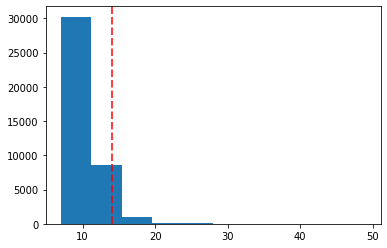

time: 222 ms (started: 2022-05-20 10:25:48 +00:00)


In [6]:
import matplotlib.pyplot as plt

whole_df = pd.concat([train_df['Caption'], test_df['Caption']], axis=0, ignore_index=True)
word_count = whole_df.apply(lambda x: len(x.split()))

seq_length = int(np.percentile(word_count, 95))
print("seq_length: ", seq_length)
plt.hist(word_count)
plt.axvline(x=seq_length,color="red",dashes=[5,2])
plt.show()

## 4.2. Defining Costum Full Dataset

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import cv2
import os

class CustomFullDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, mod='Train'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mod = mod
        self.images = dataframe['ImageID']
        self.caption = dataframe['Caption']
        self.labels = dataframe['Labels'] if mod != 'Test' else None
 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.images[index])
        img = cv2.imread(img_path)

        caption = str(self.caption[index])
        caption = " ".join(caption.split())

        encoding = self.tokenizer.encode_plus(
            caption,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True

        )
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        token_type_ids = encoding["token_type_ids"]

        if self.mod=='Train':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(),
                                transforms.RandomAffine(
                                        degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                        shear=None, interpolation=InterpolationMode.BICUBIC, 
                                        fill=tuple(np.array(np.array([0.485, 0.456, 0.406])*255).astype(int).tolist())),
                                # transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
        elif self.mod == 'Validation':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        elif self.mod == 'Test': # test
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])                       

        image = transform(img)

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach(),
            'labels': torch.tensor(self.labels[index], dtype=torch.float32) 
        } if self.mod != 'Test' else {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach()
        }
        return output

time: 37.9 ms (started: 2022-05-20 10:25:49 +00:00)


## 4.3. Defining Full Train/Valid Loader

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def create_full_train_valid_loader(train_df, tokenizer, train_batch_size, valid_batch_size, max_len):
    # split train and validation
    train_dataset, valid_dataset = train_test_split(train_df, test_size = 0.2, random_state=42)
    # reset index for train and validation
    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)
    # using Custom Full Dataset to get training and validation set
    training_set = CustomFullDataset(train_dataset, tokenizer, max_len, mod='Train')
    validation_set = CustomFullDataset(valid_dataset, tokenizer, max_len, mod='Validation')
    # using DataLoader to get training and validation loader
    training_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_set, batch_size=valid_batch_size, shuffle=True, num_workers=2)
    return training_loader, validation_loader

time: 6.78 ms (started: 2022-05-20 10:25:51 +00:00)


## 4.4. Load Models

### Download pretrained weights

In [24]:
# Load Albert best 86.04%
id = '1UP631zaUYWNS8qFkQDn64cE9uMmtAD_n'
# id = '1DkHfoNeJczD8qf_IP27L7jUfft2Nm-0f' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('albert.pt')

# Load EffNet-b3 best 85.74%
id = '1XrltFNfb4MgFgec1Mb8WdFKeI-2ARzPC'
# id = '1WmCSd_0d5S1_J7oV7e6fYWaF7Rmklfrb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('effnetb3.pt')

time: 14.3 s (started: 2022-05-20 08:10:56 +00:00)


### AlBert and EffNetB3

In [15]:
from transformers import AlbertModel
from efficientnet_pytorch import EfficientNet
from torch import nn

class AlBertClassifier(nn.Module):
    def __init__(self, dropout=0.5, n_classes=18):
        super(AlBertClassifier, self).__init__()
        self.bert = AlbertModel.from_pretrained('albert-base-v2') # cased
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids):
        _, bert_output = self.bert(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False) # , return_dict=False
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output


class EffNetB3Classifier(nn.Module):
    def __init__(self, efficientnet=EfficientNet.from_pretrained('efficientnet-b3'), dropout=0.3, n_classes=18):
        super(EffNetB3Classifier, self).__init__()
        efficientnet._fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        # self.sigm = nn.Sigmoid()

    def forward(self, x):
        # return self.sigm(self.base_model(x))
        return self.base_model(x)

Loaded pretrained weights for efficientnet-b3
time: 212 ms (started: 2022-05-20 10:32:53 +00:00)


### MLP

In [10]:
import torch.nn.functional as F
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=36, out_features=256)
        self.norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.norm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=18)

    
    def forward(self, din):

        # dout = F.relu(self.fc1(din))
        # dout = F.relu(self.fc2(dout))
        # dout = self.fc3(dout)

        # dout = F.relu(self.norm1(self.fc1(din)))
        # dout = F.relu(self.norm2(self.fc2(dout)))
        # dout = self.fc3(dout)
        # dout = F.relu(self.dropout1(self.fc1(din)))
        # dout = F.relu(self.dropout2(self.fc2(dout)))
        # dout = self.fc3(dout)
        dout = F.relu(self.fc1(din))
        dout = self.norm1(dout)
        dout = F.relu(self.fc2(dout))
        dout = self.norm2(dout)
        # dout = self.fc3(dout)
        dout = self.fc3(dout)
        return dout

time: 12.3 ms (started: 2022-05-20 10:25:56 +00:00)


### Load models

In [11]:
def load_models(device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model_albert = AlBertClassifier().to(device)
    albert_weights = torch.load('albert.pt')
    model_albert.load_state_dict(albert_weights)
    # for param in model_albert.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    model_effnet = EffNetB3Classifier().to(device)
    effnet_weights = torch.load('effnetb3.pt')
    model_effnet.load_state_dict(effnet_weights)
    # for param in model_effnet.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    return model_albert, model_effnet

time: 3.84 ms (started: 2022-05-20 10:25:57 +00:00)


## 4.5. Train and Evaluate Model

### Define train/valid/predict function

In [17]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
def calculate_f1(labels, outputs, threshold=0.5):
    outputs = (np.array(outputs) > threshold)*1
    accuracy = accuracy_score(list(labels), outputs)
    f1_score_micro = f1_score(labels, outputs, average='micro')
    f1_score_macro = f1_score(labels, outputs, average='macro')
    f1_score_sample = f1_score(labels, outputs, average='samples')
    f1_score_weighted = f1_score(labels, outputs, average='weighted')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"F1 Score (sample) = {f1_score_sample}")
    print(f"F1 Score (weighted) = {f1_score_weighted}")
    return f1_score_sample

def full_train(cv_model, nlp_model, mlp_model, optimizer, criterion, training_loader, device): 
    cv_model.train()
    nlp_model.train()
    mlp_model.train()

    train_loss = []
    train_labels = []
    train_outputs = []

    for data in tqdm(training_loader, total=len(training_loader)):

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.float)
        image = data['images'].to(device)
        
        optimizer.zero_grad()
        nlp_outputs = nlp_model(ids, mask, token_type_ids)
        cv_outputs = cv_model(image)

        concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)

        mlp_outputs = mlp_model(concat_outputs)

        loss = criterion(mlp_outputs, labels)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        # train_labels.extend(label_torch.cpu().detach().numpy().tolist())
        # train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        output=mlp_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
        for temp in output:
            train_outputs.append(list(temp))
        label = labels.detach().cpu().numpy()
        for temp in label:
            train_labels.append(list(temp))
    train_loss = np.average(train_loss)
    return train_outputs, train_labels, train_loss

def full_validation(cv_model, nlp_model, mlp_model, criterion, validation_loader, device):
    cv_model.eval()
    nlp_model.eval()
    mlp_model.eval()

    val_loss = []
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for data in tqdm(validation_loader, total=len(validation_loader)):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)
            image = data['images'].to(device)

            nlp_outputs = nlp_model(ids, mask, token_type_ids)
            cv_outputs = cv_model(image)
            
            concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)
            mlp_outputs = mlp_model(concat_outputs)

            loss = criterion(mlp_outputs, labels)
            val_loss.append(loss.item())

            output=mlp_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in output:
                val_outputs.append(list(temp))
            label = labels.detach().cpu().numpy()
            for temp in label:
               val_labels.append(list(temp))
            # val_labels.extend(label_torch.cpu().detach().numpy().tolist())
            # val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        val_loss = np.average(val_loss)
    return val_outputs, val_labels, val_loss

def full_fit(cv_model, nlp_model, mlp_model, epochs, optimizer, criterion, training_loader, validation_loader, device, threshold=0.5):
    t_loss = []
    v_loss = []
    t_f1 = []
    v_f1 = []

    best_val_loss = 1000
    best_f1 = 0
    desc_count = 0
    
    for epoch in range(epochs):
        train_outputs, train_labels, train_loss = full_train(cv_model, nlp_model, mlp_model, optimizer, criterion, training_loader, device)
        train_f1 = calculate_f1(train_labels, train_outputs, threshold)
        t_loss.append(train_loss)
        t_f1.append(train_f1)

        val_outputs, val_labels, val_loss = full_validation(cv_model, nlp_model, mlp_model, criterion, validation_loader, device)
        val_f1 = calculate_f1(val_labels, val_outputs, threshold)
        v_loss.append(val_loss)
        v_f1.append(val_f1)

        print('Epoch: {}/{} | Training Loss: {:.6f}, Training F1: {:.4f} | Validation Loss: {:.6f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,train_f1,val_loss,val_f1))
        # print('Epoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,val_loss,val_f1))

        if val_loss <= best_val_loss:
            desc_count = 0
            best_val_loss = val_loss
            torch.save(mlp_model.state_dict(), 'checkpoint.pt')
            print("\n** Checkpoint Saved!\n")

            if val_f1 >= best_f1:
                best_f1 = val_f1
                torch.save(mlp_model.state_dict(), 'full_best_f1.pt')
                print("\n** Best F1 checkpoint saved!\n")

        elif val_f1 >= best_f1:
            best_f1 = val_f1
            torch.save(mlp_model.state_dict(), 'full_best_f1.pt')
            print("\n** Best F1 checkpoint saved!\n")
        else:
            desc_count += 1
        
        if desc_count >= 3:
            print("Early Stopped At Epoch: {} / {}".format(epoch+1, epochs))
            break

    
    # best_model = mlp_model.load_state_dict(torch.load('checkpoint.pt'))
    best_model = MLPClassifier().to(device)
    best_model.load_state_dict(torch.load('checkpoint.pt'))
    
    return best_model, t_loss,t_f1,v_loss,v_f1

def full_predict(cv_model, nlp_model, mlp_model, test_df, tokenizer, max_len, test_batch_size, device):
    test_set = CustomFullDataset(test_df, tokenizer, max_len, 'Test')
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)
    cv_model.eval()
    nlp_model.eval()
    mlp_model.eval()

    test_outputs = []
    with torch.no_grad():
        for data in test_loader:
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            image = data['images'].to(device)

            nlp_outputs = nlp_model(ids, mask, token_type_ids)
            cv_outputs = cv_model(image)
            
            concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)
            mlp_outputs = mlp_model(concat_outputs)

            test_outputs.extend(torch.sigmoid(mlp_outputs).cpu().detach().numpy().tolist())
    res = (np.array(test_outputs) > 0.5)*1
    return res

time: 407 ms (started: 2022-05-20 06:15:42 +00:00)


### Set hyperparameters

In [12]:
from transformers import AlbertTokenizer, AlbertModel

seq_length = seq_length
full_learning_rates = 1e-4
full_epochs = 40
full_train_batch_size= 32
full_valid_batch_size= 32
full_test_batch_size= 32
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2') # uncased

time: 546 ms (started: 2022-05-20 10:26:04 +00:00)


### Create train/valid dataset

In [13]:
full_train_loader, full_valid_loader = create_full_train_valid_loader(train_df, tokenizer, full_train_batch_size, full_valid_batch_size, seq_length)

time: 12 ms (started: 2022-05-20 10:26:06 +00:00)


### Train model

In [26]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim import AdamW, Adam, NAdam

# train model
# load cv and nlp model, then move the model to GPU
model_albert, model_effnet = load_models()
model_mlp = MLPClassifier().to(device)

full_criterion = nn.BCEWithLogitsLoss()
# full_optimizer = AdamW(params=model_mlp.parameters(), lr=full_learning_rates)
full_optimizer = NAdam(params=model_mlp.parameters(), lr=full_learning_rates)

mlp_best_model, full_train_loss,full_train_f1,full_valid_loss,full_valid_f1 = full_fit(model_effnet, model_albert, model_mlp, full_epochs, full_optimizer, full_criterion, full_train_loader, full_valid_loader, device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.46779166666666666
F1 Score (Micro) = 0.6545705892517714
F1 Score (Macro) = 0.5257362599546274
F1 Score (sample) = 0.729394110981611
F1 Score (weighted) = 0.697679029543926


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6286666666666667
F1 Score (Micro) = 0.7996987141550546
F1 Score (Macro) = 0.7032896021443311
F1 Score (sample) = 0.8476205701705701
F1 Score (weighted) = 0.8015982188379704
Epoch: 1/40 | Training Loss: 0.560079, Training F1: 0.7294 | Validation Loss: 0.421320, Validation F1: 0.8476

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.6866666666666666
F1 Score (Micro) = 0.8420004904577124
F1 Score (Macro) = 0.7537803603682843
F1 Score (sample) = 0.8749146945646945
F1 Score (weighted) = 0.8350709280746377


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6866666666666666
F1 Score (Micro) = 0.8378027170702894
F1 Score (Macro) = 0.7167331173896329
F1 Score (sample) = 0.8684667027417027
F1 Score (weighted) = 0.8209152888219197
Epoch: 2/40 | Training Loss: 0.241686, Training F1: 0.8749 | Validation Loss: 0.152736, Validation F1: 0.8685

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7095833333333333
F1 Score (Micro) = 0.8538542134411017
F1 Score (Macro) = 0.7419744850717499
F1 Score (sample) = 0.8816780573593074
F1 Score (weighted) = 0.8377357242636541


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6888333333333333
F1 Score (Micro) = 0.8385530756023919
F1 Score (Macro) = 0.7140040053033488
F1 Score (sample) = 0.8696950109044149
F1 Score (weighted) = 0.8211454259519922
Epoch: 3/40 | Training Loss: 0.104373, Training F1: 0.8817 | Validation Loss: 0.098805, Validation F1: 0.8697

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7171666666666666
F1 Score (Micro) = 0.8589868084915666
F1 Score (Macro) = 0.7549037295022232
F1 Score (sample) = 0.8857933307433308
F1 Score (weighted) = 0.8432303459802255


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6911666666666667
F1 Score (Micro) = 0.8435366140805274
F1 Score (Macro) = 0.7310192689296067
F1 Score (sample) = 0.872233597883598
F1 Score (weighted) = 0.8269859962065357
Epoch: 4/40 | Training Loss: 0.075005, Training F1: 0.8858 | Validation Loss: 0.086348, Validation F1: 0.8722

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7229166666666667
F1 Score (Micro) = 0.8628628331079172
F1 Score (Macro) = 0.7703975714267737
F1 Score (sample) = 0.8897516804954305
F1 Score (weighted) = 0.8477868720457795


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.689
F1 Score (Micro) = 0.8386869871043376
F1 Score (Macro) = 0.7299824326181396
F1 Score (sample) = 0.871109139009139
F1 Score (weighted) = 0.8235510782108167
Epoch: 5/40 | Training Loss: 0.066525, Training F1: 0.8898 | Validation Loss: 0.085543, Validation F1: 0.8711

** Checkpoint Saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.72725
F1 Score (Micro) = 0.8650739544120699
F1 Score (Macro) = 0.7783896560890136
F1 Score (sample) = 0.8924491402116402
F1 Score (weighted) = 0.8508462669539333


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6978333333333333
F1 Score (Micro) = 0.848034627983154
F1 Score (Macro) = 0.7491580572958703
F1 Score (sample) = 0.8778195767195767
F1 Score (weighted) = 0.8338029096947244
Epoch: 6/40 | Training Loss: 0.062609, Training F1: 0.8924 | Validation Loss: 0.080773, Validation F1: 0.8778

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7310833333333333
F1 Score (Micro) = 0.8679958647171762
F1 Score (Macro) = 0.7849467532788134
F1 Score (sample) = 0.8952520622895622
F1 Score (weighted) = 0.8544394903884983


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6965
F1 Score (Micro) = 0.8484563363716554
F1 Score (Macro) = 0.7506488370104253
F1 Score (sample) = 0.8767132635882635
F1 Score (weighted) = 0.8323759683852189
Epoch: 7/40 | Training Loss: 0.060317, Training F1: 0.8953 | Validation Loss: 0.077116, Validation F1: 0.8767

** Checkpoint Saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7345
F1 Score (Micro) = 0.870062492630586
F1 Score (Macro) = 0.7888846225614983
F1 Score (sample) = 0.8967111411736411
F1 Score (weighted) = 0.8566171365070948


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6968333333333333
F1 Score (Micro) = 0.8479962612454726
F1 Score (Macro) = 0.7501536879375337
F1 Score (sample) = 0.8762731601731603
F1 Score (weighted) = 0.8338391720433174
Epoch: 8/40 | Training Loss: 0.059002, Training F1: 0.8967 | Validation Loss: 0.076956, Validation F1: 0.8763

** Checkpoint Saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7371666666666666
F1 Score (Micro) = 0.8727085478887745
F1 Score (Macro) = 0.7936852109606538
F1 Score (sample) = 0.8998130427442926
F1 Score (weighted) = 0.8596841254011786


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.696
F1 Score (Micro) = 0.849959164624898
F1 Score (Macro) = 0.7626805194649791
F1 Score (sample) = 0.8775391456582632
F1 Score (weighted) = 0.8363393419290189
Epoch: 9/40 | Training Loss: 0.058089, Training F1: 0.8998 | Validation Loss: 0.074700, Validation F1: 0.8775

** Checkpoint Saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.73725
F1 Score (Micro) = 0.8729494353145056
F1 Score (Macro) = 0.7962880389218097
F1 Score (sample) = 0.9003007034632035
F1 Score (weighted) = 0.8602703240371893


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6998333333333333
F1 Score (Micro) = 0.8494503556522252
F1 Score (Macro) = 0.7570036655873873
F1 Score (sample) = 0.8779560846560847
F1 Score (weighted) = 0.8339693066441484
Epoch: 10/40 | Training Loss: 0.057610, Training F1: 0.9003 | Validation Loss: 0.073851, Validation F1: 0.8780

** Checkpoint Saved!


** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7405
F1 Score (Micro) = 0.8738758564030339
F1 Score (Macro) = 0.7982687927802854
F1 Score (sample) = 0.9013584145021645
F1 Score (weighted) = 0.8614667816691726


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6961666666666667
F1 Score (Micro) = 0.8481955762514553
F1 Score (Macro) = 0.7559016823405852
F1 Score (sample) = 0.8772527777777778
F1 Score (weighted) = 0.8326648705237549
Epoch: 11/40 | Training Loss: 0.056963, Training F1: 0.9014 | Validation Loss: 0.076972, Validation F1: 0.8773


  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7390416666666667
F1 Score (Micro) = 0.8750788180951682
F1 Score (Macro) = 0.8029459451064248
F1 Score (sample) = 0.9009013858826359
F1 Score (weighted) = 0.8630492595531827


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.6963333333333334
F1 Score (Micro) = 0.8473269062226118
F1 Score (Macro) = 0.7578815178559911
F1 Score (sample) = 0.876225432900433
F1 Score (weighted) = 0.8324183540300996
Epoch: 12/40 | Training Loss: 0.056530, Training F1: 0.9009 | Validation Loss: 0.075360, Validation F1: 0.8762


  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7407916666666666
F1 Score (Micro) = 0.8761801601358374
F1 Score (Macro) = 0.8030073294172441
F1 Score (sample) = 0.9030784086284087
F1 Score (weighted) = 0.8643747618597157


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.7001666666666667
F1 Score (Micro) = 0.8520241973010704
F1 Score (Macro) = 0.763656391766911
F1 Score (sample) = 0.8792862433862435
F1 Score (weighted) = 0.8377067711842747
Epoch: 13/40 | Training Loss: 0.055754, Training F1: 0.9031 | Validation Loss: 0.075215, Validation F1: 0.8793

** Best F1 checkpoint saved!



  0%|          | 0/750 [00:00<?, ?it/s]

Accuracy Score = 0.7420833333333333
F1 Score (Micro) = 0.8764785103642113
F1 Score (Macro) = 0.8059386804379689
F1 Score (sample) = 0.902658155964406
F1 Score (weighted) = 0.8648408413261014


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score = 0.7001666666666667
F1 Score (Micro) = 0.8511559847819725
F1 Score (Macro) = 0.7630019019290943
F1 Score (sample) = 0.8782047619047619
F1 Score (weighted) = 0.8356098823412779
Epoch: 14/40 | Training Loss: 0.056385, Training F1: 0.9027 | Validation Loss: 0.073982, Validation F1: 0.8782
Early Stopped At Epoch: 14 / 40
time: 1h 18min 47s (started: 2022-05-20 08:11:10 +00:00)


### Save model

In [ ]:
# torch.save(mlp_best_model.state_dict(), 'mlp.pt')

time: 7.76 ms (started: 2022-05-18 17:35:35 +00:00)


## 4.6. Prediction

In [ ]:
def decoding(x):
    tmp = mlb.inverse_transform(x)
    output = []
    for i,v in enumerate(tmp):
        res = " ".join(str(j) for j in list(v))
        output.append(res)
    return output

time: 2.75 ms (started: 2022-05-18 17:36:00 +00:00)


In [ ]:
best_model = MLPClassifier().to(device)
best_model.load_state_dict(torch.load('mlp.pt'))
output = full_predict(model_effnet, model_albert, best_model, test_df, tokenizer, seq_length, full_test_batch_size, device)
pred = decoding(output)
result = {
    'ImageID':test_df['ImageID'],
    'Labels': pred
}
result = pd.DataFrame(result)
result.head(10)

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
5,30005.jpg,1
6,30006.jpg,11
7,30007.jpg,9
8,30008.jpg,9
9,30009.jpg,1


time: 37.1 s (started: 2022-05-18 17:36:02 +00:00)


In [ ]:
result.to_csv('submit_full.csv',sep=',',header=True,index=False)

time: 13.7 ms (started: 2022-05-18 17:36:39 +00:00)


# **5. Prediction**

In [34]:
!pip install SentencePiece
!pip install transformers
!pip install -U -q PyDrive
!pip install efficientnet_pytorch
!pip install pytorchtools
!pip install ipython-autotime
%load_ext autotime

from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import cv2
import os
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from transformers import AlbertTokenizer, AlbertModel
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '18S9K70mChSDbGGh7Pv2WnOPD8PjSz5kx' 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dataset.zip')

!unzip Dataset.zip



# set the data path
train_path = '/content/COMP5329S1A2Dataset/train.csv'
test_path = '/content/COMP5329S1A2Dataset/test.csv'

with open(train_path) as file:
    data = file.readlines()# Read each data in list
for i in [4790, 14716, 14961, 29895]: #These data rows all contain "/" at the end of the title, which would make them unreadable
    data[i] = data[i].replace("/", "")      
with open(train_path, 'w') as file: #Save modification
    file.writelines(data)

# load data to dataframe
with open(train_path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    train_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(test_path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    test_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

# remove all "
train_data = train_data.drop(columns = 'Caption').join(train_data['Caption'].str.replace('\"', ''))
test_data = test_data.drop(columns = 'Caption').join(test_data['Caption'].str.replace('\"', ''))

# copy data from train_data, test_data
train_df = train_data.copy()
test_df = test_data.copy()

from sklearn.preprocessing import MultiLabelBinarizer
# encode labels for train data
labels = []
for i in train_df['Labels']:
    labels.append(i.split())
labels = [sorted(int(j) for j in i) for i in labels]

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(labels)

train_df['Labels'] = list(label_encoded)

class AlBertClassifier(nn.Module):
    def __init__(self, dropout=0.5, n_classes=18):
        super(AlBertClassifier, self).__init__()
        self.bert = AlbertModel.from_pretrained('albert-base-v2') # cased
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids):
        _, bert_output = self.bert(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False) # , return_dict=False
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output

class EffNetB3Classifier(nn.Module):
    def __init__(self, efficientnet=EfficientNet.from_pretrained('efficientnet-b3'), dropout=0.5, n_classes=18):
        super(EffNetB3Classifier, self).__init__()
        efficientnet._fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        # self.sigm = nn.Sigmoid()

    def forward(self, x):
        # return self.sigm(self.base_model(x))
        return self.base_model(x)

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=36, out_features=256)
        self.norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.norm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=18)

    
    def forward(self, din):

        # dout = F.relu(self.fc1(din))
        # dout = F.relu(self.fc2(dout))
        # dout = self.fc3(dout)

        # dout = F.relu(self.norm1(self.fc1(din)))
        # dout = F.relu(self.norm2(self.fc2(dout)))
        # dout = self.fc3(dout)
        # dout = F.relu(self.dropout1(self.fc1(din)))
        # dout = F.relu(self.dropout2(self.fc2(dout)))
        # dout = self.fc3(dout)
        dout = F.relu(self.fc1(din))
        dout = self.norm1(dout)
        dout = F.relu(self.fc2(dout))
        dout = self.norm2(dout)
        # dout = self.fc3(dout)
        dout = self.fc3(dout)
        return dout

class CustomFullDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, mod='Train'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mod = mod
        self.images = dataframe['ImageID']
        self.caption = dataframe['Caption']
        self.labels = dataframe['Labels'] if mod != 'Test' else None
 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.images[index])
        img = cv2.imread(img_path)

        caption = str(self.caption[index])
        caption = " ".join(caption.split())

        encoding = self.tokenizer.encode_plus(
            caption,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True

        )
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        token_type_ids = encoding["token_type_ids"]

        if self.mod=='Train':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(),
                                transforms.RandomAffine(
                                        degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                        shear=None, interpolation=InterpolationMode.BICUBIC, 
                                        fill=tuple(np.array(np.array([0.485, 0.456, 0.406])*255).astype(int).tolist())),
                                # transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
        elif self.mod == 'Validation':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        elif self.mod == 'Test': # test
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])                       

        image = transform(img)

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach(),
            'labels': torch.tensor(self.labels[index], dtype=torch.float32) 
        } if self.mod != 'Test' else {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach()
        }
        return output

def download_models():
    # Load Albert
    id = '1UP631zaUYWNS8qFkQDn64cE9uMmtAD_n' 
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('albert.pt')

    # Load EffNet-b3
    id = '1XrltFNfb4MgFgec1Mb8WdFKeI-2ARzPC'
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('effnetb3.pt')

    # Load MLP
    id = '1YN-0PRJkDKzBt_u6LGRtRr7v4SEAG5MB'
    downloaded = drive.CreateFile({'id':id})
    downloaded.GetContentFile('mlp.pt')

def load_all_models(device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model_albert = AlBertClassifier().to(device)
    albert_weights = torch.load('albert.pt')
    model_albert.load_state_dict(albert_weights)
    # for param in model_albert.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    model_effnet = EffNetB3Classifier().to(device)
    effnet_weights = torch.load('effnetb3.pt')
    model_effnet.load_state_dict(effnet_weights)
    # for param in model_effnet.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    model_mlp = MLPClassifier().to(device)
    model_weights = torch.load('mlp.pt')
    model_mlp.load_state_dict(model_weights)

    return model_albert, model_effnet, model_mlp

def decoding(x):
    tmp = mlb.inverse_transform(x)
    output = []
    for i,v in enumerate(tmp):
        res = " ".join(str(j) for j in list(v))
        output.append(res)
    return output

def predict(train_df, test_df, tokenizer=AlbertTokenizer.from_pretrained('albert-base-v2'), device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    # get seq_length
    whole_df = pd.concat([train_df['Caption'], test_df['Caption']], axis=0, ignore_index=True)
    word_count = whole_df.apply(lambda x: len(x.split()))
    max_len = int(np.percentile(word_count, 95))

    # download and get models
    download_models()
    nlp_model, cv_model, mlp_model = load_all_models()

    # create DataLoader for test set
    test_set = CustomFullDataset(test_df, tokenizer, max_len, 'Test')
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)
    
    # set all models as eval mod
    cv_model.eval()
    nlp_model.eval()
    mlp_model.eval()

    test_outputs = []
    with torch.no_grad():
        for data in test_loader:
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            image = data['images'].to(device)

            nlp_outputs = nlp_model(ids, mask, token_type_ids)
            cv_outputs = cv_model(image)
            
            concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)
            mlp_outputs = mlp_model(concat_outputs)

            test_outputs.extend(torch.sigmoid(mlp_outputs).cpu().detach().numpy().tolist())
    
    # decoding result
    res = (np.array(test_outputs) > 0.5)*1
    pred = decoding(res)

    # create result dataframe
    result = {
        'ImageID':test_df['ImageID'],
        'Labels': pred
    }
    result = pd.DataFrame(result)
    
    # save as csv file
    result.to_csv('predication.csv',sep=',',header=True,index=False)
    return result

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Archive:  Dataset.zip
replace COMP5329S1A2Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Loaded pretrained weights for efficientnet-b3
time: 28.8 s (started: 2022-05-20 11:07:16 +00:00)


In [ ]:
pred_result = predict(train_df, test_df)
pred_result.head(10)

# **6. Appendix**

Not the Best Model here. Because Albert + EfficientNetB4 is over 100M, we did not use it.

## 6.1. EfficientNetB4

### 6.1.1. Defining Costum CV Dataset

In [ ]:
def expend_img(img):
    fill_pix=[0,0,0]
    h,w=img.shape[:2]
    if h>=w:
        padd_width=int(h-w)//2
        padd_top,padd_bottom,padd_left,padd_right=0,0,padd_width,padd_width
    elif h<w:
        padd_high=int(w-h)//2
        padd_top,padd_bottom,padd_left,padd_right=padd_high,padd_high,0,0
    new_img = cv2.copyMakeBorder(img,padd_top,padd_bottom,padd_left,padd_right,cv2.BORDER_CONSTANT, value=fill_pix)
    return new_img

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import cv2
import os

class CustomCVDataset(Dataset):
    def __init__(self, dataframe, mod='Train'):
        self.data = dataframe
        self.mod = mod
        self.images = dataframe['ImageID']
        self.labels = dataframe['Labels'] if mod != 'Test' else None
 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.images[index])
        # img = Image.open(img_path)
        img = cv2.imread(img_path)
        img = expend_img(img)

        if self.mod=='Train':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                # transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomHorizontalFlip(),
                                # transforms.Grayscale(),
                                transforms.ColorJitter(),
                                transforms.RandomAffine(
                                        degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                        shear=None, resample=False, 
                                        fill=tuple(np.array(np.array([0.485, 0.456, 0.406])*255).astype(int).tolist())),
                                # transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
        elif self.mod == 'Validation':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        elif self.mod == 'Test': # test
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])                       

        image = transform(img)

        output = {
            # 'images': torch.tensor(image, dtype=torch.float32),
            'images': image.clone().detach(),
            # 'labels': self.labels[index].clone().detach()
            'labels': torch.tensor(self.labels[index], dtype=torch.float32) 
        } if self.mod != 'Test' else {
            # 'images': torch.tensor(image)
            'images': image.clone().detach()
        }
        return output

In [ ]:
# Check transformed image, binarized label and caption
sample_data = CustomCVDataset(train_df, "Train")

def transformed_image(sample):
    img = sample.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# print(sample_data[0])

transformed_image(sample_data[0]['images']) #Tensor, size=[3, 256, 256]
# print(f'encoded_caption: {sample_data[0][1]}')#ndarray, length=28
# print(f'caption: {sample_data[0][2]}') #str
print(f'label: {sample_data[0]["labels"]}') #ndarray, length=18

### 6.1.2. Defining CV Train / Valid Loader

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def create_cv_train_valid_loader(train_df, train_batch_size, valid_batch_size):
    train_dataset, valid_dataset = train_test_split(train_df, test_size = 0.2, random_state=42)
    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)
    training_set = CustomCVDataset(train_dataset, mod='Train')
    validation_set = CustomCVDataset(valid_dataset, mod='Validation')
    
    training_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_set, batch_size=valid_batch_size, shuffle=True, num_workers=2)
    return training_loader, validation_loader

### 6.1.3. Defining EfficientNetB4 Model

In [ ]:
from efficientnet_pytorch import EfficientNet
from torch import nn
# efficientnet = EfficientNet.from_pretrained('efficientnet-b3') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class EffNetB4Classifier(nn.Module):
    def __init__(self, efficientnet=EfficientNet.from_pretrained('efficientnet-b4'), dropout=0.4, n_classes=18):
        super(EffNetB4Classifier, self).__init__()
        efficientnet._fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

### 6.1.4. Train and Evaluate Model

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
def calculate_f1(labels, outputs, threshold=0.5):
    outputs = (np.array(outputs) > threshold)*1
    accuracy = accuracy_score(list(labels), outputs)
    f1_score_micro = f1_score(labels, outputs, average='micro')
    f1_score_macro = f1_score(labels, outputs, average='macro')
    f1_score_sample = f1_score(labels, outputs, average='samples')
    f1_score_weighted = f1_score(labels, outputs, average='weighted')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"F1 Score (sample) = {f1_score_sample}")
    print(f"F1 Score (weighted) = {f1_score_weighted}")
    return f1_score_sample

def cv_train(model, optimizer, criterion, training_loader, device): 
    model.train()

    train_loss = []
    train_labels = []
    train_outputs = []
    for data in tqdm(training_loader, total=len(training_loader)):
        image_torch = data['images'].to(device)
        label_torch = data['labels'].to(device, dtype = torch.float)
        
        optimizer.zero_grad()
        outputs = model(image_torch)

        loss = criterion(outputs, label_torch)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        # train_labels.extend(label_torch.cpu().detach().numpy().tolist())
        # train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        output=outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
        for temp in output:
            train_outputs.append(list(temp))
        label = label_torch.detach().cpu().numpy()
        for temp in label:
            train_labels.append(list(temp))
    train_loss = np.average(train_loss)
    return train_outputs, train_labels, train_loss

def cv_validation(model, criterion, validation_loader, device):
    model.eval()

    val_loss = []
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for data in tqdm(validation_loader, total=len(validation_loader)):
            image_torch = data['images'].to(device)
            label_torch = data['labels'].to(device, dtype = torch.float)

            outputs = model(image_torch)
            loss = criterion(outputs, label_torch)
            val_loss.append(loss.item())

            output=outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in output:
                val_outputs.append(list(temp))
            label = label_torch.detach().cpu().numpy()
            for temp in label:
               val_labels.append(list(temp))
            # val_labels.extend(label_torch.cpu().detach().numpy().tolist())
            # val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        val_loss = np.average(val_loss)
    return val_outputs, val_labels, val_loss

def cv_fit(model, epochs, optimizer, criterion, training_loader, validation_loader, device, threshold=0.5):
    t_loss = []
    v_loss = []
    t_f1 = []
    v_f1 = []

    best_val_loss = 1000
    best_f1 = 0
    desc_count = 0

    for epoch in range(epochs):
        train_outputs, train_labels, train_loss = cv_train(model, optimizer, criterion, training_loader, device)
        train_f1 = calculate_f1(train_labels, train_outputs, threshold)
        t_loss.append(train_loss)
        t_f1.append(train_f1)
        val_outputs, val_labels, val_loss = cv_validation(model, criterion, validation_loader, device)
        val_f1 = calculate_f1(val_labels, val_outputs, threshold)
        v_loss.append(val_loss)
        v_f1.append(val_f1)
        print('Epoch: {}/{} | Training Loss: {:.6f}, Training F1: {:.4f} | Validation Loss: {:.6f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,train_f1,val_loss,val_f1))
        # print('Epoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,val_loss,val_f1))


        if val_loss < best_val_loss:
            desc_count = 0
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'cv_checkpoint.pt')
            print("\n** Checkpoint Saved!\n")

            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save(model.state_dict(), 'cv_best_f1.pt')
                print("\n** Best F1 checkpoint saved!\n")

        elif val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'cv_best_f1.pt')
            print("\n** Best F1 checkpoint saved!\n")
        else:
            desc_count += 1
        
        if desc_count >= 3:
            print("Early Stopped At Epoch: {} / {}".format(epoch+1, epochs))
            break

    return t_loss,t_f1,v_loss,v_f1

def cv_predict(model, test_df, est_batch_size, device):
    test_set = CustomCVDataset(test_df, 'Test')
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)
    model.eval()

    test_outputs = []
    with torch.no_grad():
        for image in test_loader:
            image_torch = image.to(device)

            outputs = model(image_torch)
            test_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    res = (np.array(test_outputs) > 0.5)*1
    return res

In [ ]:
cv_train_batch_size = 32
cv_valid_batch_size = 32
cv_test_batch_size = 32
cv_epochs = 30
cv_learning_rates = 1e-4

In [ ]:
cv_train_loader, cv_valid_loader = create_cv_train_valid_loader(train_df, cv_train_batch_size, cv_valid_batch_size)

In [ ]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim import AdamW, Adam, NAdam

# train model
# Move the model to GPU
cv_model_b4 = EffNetB4Classifier().to(device)
cv_criterion = nn.BCELoss()
# cv_criterion = nn.BCEWithLogitsLoss()
# optimizer = Adam(params=model.parameters(), lr=learning_rates)
cv_optimizer = Adam(params=cv_model_b4.parameters(), lr=cv_learning_rates)

cv_train_loss, cv_train_f1, cv_valid_loss, cv_valid_f1 = cv_fit(cv_model_b4, cv_epochs, cv_optimizer, cv_criterion, cv_train_loader, cv_valid_loader, device)

In [ ]:
# from google.colab import files
# torch.save(cv_model_b4.state_dict(), 'effnetb4.pt')
# files.download('effnetb4.pt')

# best_cv = EffNetB4Classifier().to(device)
# best_cv.load_state_dict('cv_checkpoint.pt')

## 6.2. AlBert + EfficientNetB4

### 6.2.1. Define Seq-length

In [ ]:
import matplotlib.pyplot as plt

whole_df = pd.concat([train_df['Caption'], test_df['Caption']], axis=0, ignore_index=True)
word_count = whole_df.apply(lambda x: len(x.split()))

seq_length = int(np.percentile(word_count, 95))
print("seq_length: ", seq_length)
plt.hist(word_count)
plt.axvline(x=seq_length,color="red",dashes=[5,2])
plt.show()

### 6.2.2. Defining Costum Full Dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import cv2
import os

class CustomFullDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, mod='Train'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mod = mod
        self.images = dataframe['ImageID']
        self.caption = dataframe['Caption']
        self.labels = dataframe['Labels'] if mod != 'Test' else None
 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.images[index])
        img = cv2.imread(img_path)

        caption = str(self.caption[index])
        caption = " ".join(caption.split())

        encoding = self.tokenizer.encode_plus(
            caption,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True

        )
        ids = encoding['input_ids']
        mask = encoding['attention_mask']
        token_type_ids = encoding["token_type_ids"]

        if self.mod=='Train':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(),
                                transforms.RandomAffine(
                                        degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                        shear=None, interpolation=InterpolationMode.BICUBIC, 
                                        fill=tuple(np.array(np.array([0.485, 0.456, 0.406])*255).astype(int).tolist())),
                                # transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
        elif self.mod == 'Validation':
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        elif self.mod == 'Test': # test
            transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])                       

        image = transform(img)

        output = {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach(),
            'labels': torch.tensor(self.labels[index], dtype=torch.float32) 
        } if self.mod != 'Test' else {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'images': image.clone().detach()
        }
        return output

### 6.2.3. Defining Full Train/Valid Loader

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def create_full_train_valid_loader(train_df, tokenizer, train_batch_size, valid_batch_size, max_len):
    # split train and validation
    train_dataset, valid_dataset = train_test_split(train_df, test_size = 0.2, random_state=42)
    # reset index for train and validation
    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)
    # using Custom Full Dataset to get training and validation set
    training_set = CustomFullDataset(train_dataset, tokenizer, max_len, mod='Train')
    validation_set = CustomFullDataset(valid_dataset, tokenizer, max_len, mod='Validation')
    # using DataLoader to get training and validation loader
    training_loader = DataLoader(training_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_set, batch_size=valid_batch_size, shuffle=True, num_workers=2)
    return training_loader, validation_loader

### 6.2.4. Load Models

In [ ]:
# Load Albert
id = '1DkHfoNeJczD8qf_IP27L7jUfft2Nm-0f' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('albert.pt')

# Load EffNet-b4
id = '1pin4l5e0hGr3_z1BxtAzBJic7aSqdkgO'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('effnetb4.pt')

In [ ]:
from transformers import AlbertModel
from efficientnet_pytorch import EfficientNet
from torch import nn

class AlBertClassifier(nn.Module):
    def __init__(self, dropout=0.5, n_classes=18):
        super(AlBertClassifier, self).__init__()
        self.bert = AlbertModel.from_pretrained('albert-base-v2') # cased
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, ids, mask, token_type_ids):
        _, bert_output = self.bert(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False) # , return_dict=False
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output


class EffNetB4Classifier(nn.Module):
    def __init__(self, efficientnet=EfficientNet.from_pretrained('efficientnet-b4'), dropout=0.4, n_classes=18):
        super(EffNetB4Classifier, self).__init__()
        efficientnet._fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        # self.sigm = nn.Sigmoid()

    def forward(self, x):
        # return self.sigm(self.base_model(x))
        return self.base_model(x)

In [ ]:
import torch.nn.functional as F
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=36, out_features=256)
        self.norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.norm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=18)

    
    def forward(self, din):

        # dout = F.relu(self.fc1(din))
        # dout = F.relu(self.fc2(dout))
        # dout = self.fc3(dout)

        # dout = F.relu(self.norm1(self.fc1(din)))
        # dout = F.relu(self.norm2(self.fc2(dout)))
        # dout = self.fc3(dout)
        # dout = F.relu(self.dropout1(self.fc1(din)))
        # dout = F.relu(self.dropout2(self.fc2(dout)))
        # dout = self.fc3(dout)
        dout = F.relu(self.fc1(din))
        dout = self.norm1(dout)
        dout = F.relu(self.fc2(dout))
        dout = self.norm2(dout)
        # dout = self.fc3(dout)
        dout = self.fc3(dout)
        return dout

In [ ]:
def load_models(device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model_albert = AlBertClassifier().to(device)
    albert_weights = torch.load('albert.pt')
    model_albert.load_state_dict(albert_weights)
    # for param in model_albert.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    model_effnet = EffNetB4Classifier().to(device)
    effnet_weights = torch.load('effnetb4.pt')
    model_effnet.load_state_dict(effnet_weights)
    # for param in model_effnet.parameters(): #Parameters can be updated
    #     param.requires_grad=True

    return model_albert, model_effnet

### 6.2.5. Train and Evaluate Model

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
def calculate_f1(labels, outputs, threshold=0.5):
    outputs = (np.array(outputs) > threshold)*1
    accuracy = accuracy_score(list(labels), outputs)
    f1_score_micro = f1_score(labels, outputs, average='micro')
    f1_score_macro = f1_score(labels, outputs, average='macro')
    f1_score_sample = f1_score(labels, outputs, average='samples')
    f1_score_weighted = f1_score(labels, outputs, average='weighted')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"F1 Score (sample) = {f1_score_sample}")
    print(f"F1 Score (weighted) = {f1_score_weighted}")
    return f1_score_sample

def full_train(cv_model, nlp_model, mlp_model, optimizer, criterion, training_loader, device): 
    cv_model.train()
    nlp_model.train()
    mlp_model.train()

    train_loss = []
    train_labels = []
    train_outputs = []

    for data in tqdm(training_loader, total=len(training_loader)):

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        labels = data['labels'].to(device, dtype = torch.float)
        image = data['images'].to(device)
        
        optimizer.zero_grad()
        nlp_outputs = nlp_model(ids, mask, token_type_ids)
        cv_outputs = cv_model(image)

        concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)

        mlp_outputs = mlp_model(concat_outputs)

        loss = criterion(mlp_outputs, labels)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        # train_labels.extend(label_torch.cpu().detach().numpy().tolist())
        # train_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        output=mlp_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
        for temp in output:
            train_outputs.append(list(temp))
        label = labels.detach().cpu().numpy()
        for temp in label:
            train_labels.append(list(temp))
    train_loss = np.average(train_loss)
    return train_outputs, train_labels, train_loss

def full_validation(cv_model, nlp_model, mlp_model, criterion, validation_loader, device):
    cv_model.eval()
    nlp_model.eval()
    mlp_model.eval()

    val_loss = []
    val_labels = []
    val_outputs = []
    with torch.no_grad():
        for data in tqdm(validation_loader, total=len(validation_loader)):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)
            image = data['images'].to(device)

            nlp_outputs = nlp_model(ids, mask, token_type_ids)
            cv_outputs = cv_model(image)
            
            concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)
            mlp_outputs = mlp_model(concat_outputs)

            loss = criterion(mlp_outputs, labels)
            val_loss.append(loss.item())

            output=mlp_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in output:
                val_outputs.append(list(temp))
            label = labels.detach().cpu().numpy()
            for temp in label:
               val_labels.append(list(temp))
            # val_labels.extend(label_torch.cpu().detach().numpy().tolist())
            # val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        val_loss = np.average(val_loss)
    return val_outputs, val_labels, val_loss

def full_fit(cv_model, nlp_model, mlp_model, epochs, optimizer, criterion, training_loader, validation_loader, device, threshold=0.5):
    t_loss = []
    v_loss = []
    t_f1 = []
    v_f1 = []

    best_val_loss = 1000
    best_f1 = 0
    desc_count = 0
    
    for epoch in range(epochs):
        train_outputs, train_labels, train_loss = full_train(cv_model, nlp_model, mlp_model, optimizer, criterion, training_loader, device)
        train_f1 = calculate_f1(train_labels, train_outputs, threshold)
        t_loss.append(train_loss)
        t_f1.append(train_f1)

        val_outputs, val_labels, val_loss = full_validation(cv_model, nlp_model, mlp_model, criterion, validation_loader, device)
        val_f1 = calculate_f1(val_labels, val_outputs, threshold)
        v_loss.append(val_loss)
        v_f1.append(val_f1)

        print('Epoch: {}/{} | Training Loss: {:.6f}, Training F1: {:.4f} | Validation Loss: {:.6f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,train_f1,val_loss,val_f1))
        # print('Epoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}, Validation F1: {:.4f}'.format(epoch+1,epochs,train_loss,val_loss,val_f1))

        if val_loss <= best_val_loss:
            desc_count = 0
            best_val_loss = val_loss
            torch.save(mlp_model.state_dict(), 'checkpoint.pt')
            print("\n** Checkpoint Saved!\n")

            if val_f1 >= best_f1:
                best_f1 = val_f1
                torch.save(mlp_model.state_dict(), 'full_best_f1.pt')
                print("\n** Best F1 checkpoint saved!\n")

        elif val_f1 >= best_f1:
            best_f1 = val_f1
            torch.save(mlp_model.state_dict(), 'full_best_f1.pt')
            print("\n** Best F1 checkpoint saved!\n")
        else:
            desc_count += 1
        
        if desc_count >= 3:
            print("Early Stopped At Epoch: {} / {}".format(epoch+1, epochs))
            break

    
    # best_model = mlp_model.load_state_dict(torch.load('checkpoint.pt'))
    best_model = MLPClassifier().to(device)
    best_model.load_state_dict(torch.load('checkpoint.pt'))
    
    return best_model,t_loss,t_f1,v_loss,v_f1

def full_predict(cv_model, nlp_model, mlp_model, test_df, tokenizer, max_len, test_batch_size, device):
    test_set = CustomFullDataset(test_df, tokenizer, max_len, 'Test')
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=2)
    cv_model.eval()
    nlp_model.eval()
    mlp_model.eval()

    test_outputs = []
    with torch.no_grad():
        for data in test_loader:
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            image = data['images'].to(device)

            nlp_outputs = nlp_model(ids, mask, token_type_ids)
            cv_outputs = cv_model(image)
            
            concat_outputs = torch.cat((nlp_outputs, cv_outputs),1)
            mlp_outputs = mlp_model(concat_outputs)

            test_outputs.extend(torch.sigmoid(mlp_outputs).cpu().detach().numpy().tolist())
    res = (np.array(test_outputs) > 0.5)*1
    return res

In [ ]:
from transformers import AlbertTokenizer, AlbertModel

seq_length = seq_length
full_learning_rates = 1e-4
full_epochs = 40
full_train_batch_size= 32
full_valid_batch_size= 32
full_test_batch_size= 32
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2') # uncased

In [ ]:
full_train_loader, full_valid_loader = create_full_train_valid_loader(train_df, tokenizer, full_train_batch_size, full_valid_batch_size, seq_length)

In [ ]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim import AdamW, Adam, NAdam

# train model
# load cv and nlp model, then move the model to GPU
model_albert, model_effnet = load_models()
model_mlp = MLPClassifier().to(device)

full_criterion = nn.BCEWithLogitsLoss()
# full_optimizer = AdamW(params=model_mlp.parameters(), lr=full_learning_rates)
full_optimizer = NAdam(params=model_mlp.parameters(), lr=full_learning_rates)
mlp_best_model, full_train_loss,full_train_f1,full_valid_loss,full_valid_f1 = full_fit(model_effnet, model_albert, model_mlp, full_epochs, full_optimizer, full_criterion, full_train_loader, full_valid_loader, device)